<a href="https://colab.research.google.com/github/abhinav70291/TechnicalAnalysis-for-intra-day-trading/blob/main/Technical_Analysis_underwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade ipywidgets matplotlib
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectMultiple, SelectionRangeSlider
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.7 MB/s eta 0:00:00


In [2]:
df=pd.read_csv("/content/Manappuram_10minute.csv")
df.tail(5)

,Date,Open,High,Low,Close,Volume
2492,2020-04-28T14:35:00,123.90,124.25,123.7,124.15,289726
2493,2020-04-28T14:45:00,124.15,125.80,124.1,125.80,1706683
2494,2020-04-28T14:55:00,125.80,125.80,125.8,125.80,145240
2495,2020-04-28T15:05:00,125.80,131.50,125.8,130.85,3162404
2496,2020-04-28T15:15:00,130.95,130.95,129.6,129.75,221556


In [3]:
# Converting Date column into datetime dftype
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# **State the Values you want to consider for this backtesting and technical analysis**

In [4]:
# Initialize a DataFrame to store metrics for each parameter
metrics_df = pd.DataFrame(columns=['indicator', 'hit_rate', 'profit_factor', 'sharpe_ratio', 'max_drawdown', 'total_profit', 'profit_percentage', 'avg_win_to_avg_loss_ratio', 'sortino_ratio', 'num_trades'])

# **Defining ALL indicator functions  here**

In [5]:
# calculates SMA using "n" as the rolling window size
def ma_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  return df

# calculates SMA using "m" and "n" as the rolling window size
def longshort_ma_calc(df, m, n):
  df["sma_short"] = df.Close.rolling(window=min(m,n)).mean()
  df["sma_long"] = df.Close.rolling(window=max(m,n)).mean()
  return df

# calculates EMA using "n" as the rolling window size
def ema_calc(df, n):
  df["ema"] = df.Close.ewm(span=n, adjust=False).mean()
  return df


def longshort_ema_calc(df, m, n):
  df["ema_short"] = df.Close.ewm(span=min(m,n), adjust=False).mean()
  df["ema_long"] = df.Close.ewm(span=max(m,n), adjust=False).mean()
  return df

# calculates RSI using "n" as the lookback period
def rsi_calc(df, n):
  df['rsi'] = 100 - (100 / (1 + df['Close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=n).mean() / df['Close'].diff().apply(lambda x: -x if x < 0 else 0).rolling(window=n).mean()))
  return df

# calculates OBV
def obv_calc(df):
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  return df

def bb_calc(df, n):
  df["sma"] = df.Close.rolling(window=n).mean()
  df["std"] = df.Close.rolling(window=n).std()
  df["upper_bb"] = df["sma"] + (2 * df["std"])
  df["lower_bb"] = df["sma"] - (2 * df["std"])
  return df

# Volume weighted average price
def vwap_calc(df):
    df['vwap'] = (df['Volume'] * df['Close']).cumsum() / df['Volume'].cumsum()
    return df

# Supertrend Indicator
def supertrend_calc(df, period, multiplier):
    # Calculate basic upper and lower bands
    df['hl_avg'] = (df['High'] + df['Low']) / 2
    df['range'] = df['High'] - df['Low']
    df['upper_band'] = df['hl_avg'] + multiplier * df['range']
    df['lower_band'] = df['hl_avg'] - multiplier * df['range']

    # Calculate final upper and lower bands
    df['upper_band_final'] = np.where((df['upper_band'] < df['upper_band'].shift(1)) | (df['Close'] > df['upper_band'].shift(1)), df['upper_band'], df['upper_band'].shift(1))
    df['lower_band_final'] = np.where((df['lower_band'] > df['lower_band'].shift(1)) | (df['Close'] < df['lower_band'].shift(1)), df['lower_band'], df['lower_band'].shift(1))

    # Calculate Supertrend
    df['supertrend'] = np.where(df['Close'] <= df['upper_band_final'], df['upper_band_final'], df['lower_band_final'])
    df['supertrend'] = np.where(df['Close'] >= df['lower_band_final'], df['lower_band_final'], df['supertrend'])

    return df

# calculates Average Directional Index (ADX)
def adx_calc(df, n):
    df['hl_diff'] = df['High'] - df['Low']
    df['hc_diff'] = abs(df['High'] - df['Close'].shift(1))
    df['lc_diff'] = abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['hl_diff', 'hc_diff', 'lc_diff']].max(axis=1)
    df['+dm'] = np.where((df['High'] > df['High'].shift(1)) & (df['High'] - df['High'].shift(1) > df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-dm'] = np.where((df['Low'] < df['Low'].shift(1)) & (df['High'].shift(1) - df['High'] < df['Low'].shift(1) - df['Low']), df['Low'].shift(1) - df['Low'], 0)
    df['tr_ema'] = df['tr'].ewm(span=n, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=n, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=n, adjust=False).mean()
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].rolling(window=n).mean()

    return df

# calculates MACD
def macd_calc(df, short_n, long_n, signal_n):
    df['ema_short'] = df['Close'].ewm(span=short_n, adjust=False).mean()
    df['ema_long'] = df['Close'].ewm(span=long_n, adjust=False).mean()
    df['macd_line'] = df['ema_short'] - df['ema_long']
    df['signal_line'] = df['macd_line'].ewm(span=signal_n, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['signal_line']

    return df


# **Backtesting starts from here**
**Our Indicators for consideration here are -**

(i)  SMA

(ii) Short term SMA and Long term SMA

(iii) EMA

(iv) Short term EMA and Long term EMA

(v) RSI

(vi) Average Directional Index

(vii)  Bollinger Bands



In [6]:
# Run the loop and find the optimal parameters
starting_capital = 10000  # Starting capital in your currency
stop_loss = 0.05  # Stop loss level (5% in this case)
upper_cap = 8000  # Upper investment cap in your currency
lower_cap = 1000  # Lower investment cap in your currency
transaction_cost = 0.001  # Transaction cost (0.1% in this case)
leverage = 1 # Leverage (1x in this case meaning no leverage, just the original capital)
volume_percentage = 0.001  # Minimum average daily volume

**SMA**

In [7]:
# metrics_df=pd.DataFrame()

In [8]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

def find_extrema(df, n):
    df['min'] = df.iloc[argrelextrema(df['Close'].values, np.less_equal, order=n)[0]]['Close']
    df['max'] = df.iloc[argrelextrema(df['Close'].values, np.greater_equal, order=n)[0]]['Close']
    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
    df = find_extrema(df, n)
    df['signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and not np.isnan(row['min']):
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'signal'] = 1  # Indicate a buy decision

            if in_position and (not np.isnan(row['max']) and row.Close < buyprice * (1 - stop_loss)):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if in_position and index == df_day.index[-1]:
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
    sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_extrema = {}

for n in range(1, 38*30):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_extrema[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_extrema, key=lambda x: metrics_dict_extrema[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)

# Run the backtest function with the best n to get the signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)

# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"Local Extrema",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: 1, Hit Rate: 0.5151515151515151, Profit Factor: 1.955600570315761, Sharpe Ratio: 10.046083282665279, Max Drawdown: -968.9999999999991, Total Profit: 4411.815050000056, Profit Percentage: 44.11815050000056%, Average Win to Average Loss ratio: 1.836024791190608, Sortino Ratio: 17.71820129371497, Number of Trades: 68
For parameter: 2, Hit Rate: 0.5454545454545454, Profit Factor: 2.089990647397023, Sharpe Ratio: 10.820350122191634, Max Drawdown: -961.4499999999998, Total Profit: 4471.191810500062, Profit Percentage: 44.71191810500063%, Average Win to Average Loss ratio: 1.7997141685918807, Sortino Ratio: 19.96481811867254, Number of Trades: 67
For parameter: 3, Hit Rate: 0.5909090909090909, Profit Factor: 2.5507797407071213, Sharpe Ratio: 13.208412150452896, Max Drawdown: -961.4499999999998, Total Profit: 5596.836541400058, Profit Percentage: 55.96836541400059%, Average Win to Average Loss ratio: 1.8313290446102406, Sortino Ratio: 22.142375277144467, Number of Trades: 67
For

In [ ]:
df.head(50)

In [10]:
import numpy as np
import pandas as pd

def ma_calc(df, n):
    df['sma'] = df['Close'].rolling(n).mean()
    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
    df = ma_calc(df, n)
    df['sma_signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.Close > row.sma:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'sma_signal'] = 1  # Indicate a buy decision

            if in_position and (row.Close < row.sma and row.Close < buyprice * (1 - stop_loss)) :
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'sma_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if in_position and index == df_day.index[-1]:
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'sma_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

        daily_profits.append(sum(profits))



    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
    sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_sma = {}

for n in range(304, 570):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_sma[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_sma, key=lambda x: metrics_dict_sma[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"SMA",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)



For parameter: 304, Hit Rate: 0.22727272727272727, Profit Factor: 1.4263239931851956, Sharpe Ratio: 4.504034067246991, Max Drawdown: -490.0000000000009, Total Profit: 682.9377000000204, Profit Percentage: 6.829377000000204%, Average Win to Average Loss ratio: 1.333560831926434, Sortino Ratio: 5.5875792465479845, Number of Trades: 31
For parameter: 305, Hit Rate: 0.22727272727272727, Profit Factor: 1.4263239931851956, Sharpe Ratio: 4.504034067246991, Max Drawdown: -490.0000000000009, Total Profit: 698.5669000000198, Profit Percentage: 6.985669000000199%, Average Win to Average Loss ratio: 1.2446567764646719, Sortino Ratio: 5.5875792465479845, Number of Trades: 30
For parameter: 306, Hit Rate: 0.22727272727272727, Profit Factor: 1.4423753665689147, Sharpe Ratio: 4.628410030424003, Max Drawdown: -490.0000000000009, Total Profit: 728.9218000000183, Profit Percentage: 7.289218000000183%, Average Win to Average Loss ratio: 1.258535522301322, Sortino Ratio: 5.6723485273399, Number of Trades: 

In [11]:
 # Initialize the signal column with hold signals
df['signal'] = 0

# Generate buy signals at local minima
df.loc[df['min'].notna(), 'signal'] = 1

# Generate sell signals at local maxima
df.loc[df['max'].notna(), 'signal'] = -1

df.head(20)

,Open,High,Low,Close,Volume,min,max,signal,sma,sma_signal
Date,,,,,,,,,,
2020-01-21 09:15:00,179.30,180.20,178.25,180.15,173897,NaN,NaN,0,NaN,0
2020-01-21 09:25:00,180.00,181.30,180.00,180.50,175277,NaN,NaN,0,NaN,0
2020-01-21 09:35:00,180.50,181.05,180.25,180.55,110920,NaN,NaN,0,NaN,0
2020-01-21 09:45:00,180.55,181.50,180.05,181.35,80456,NaN,181.35,-1,NaN,0
2020-01-21 09:55:00,181.35,181.65,181.00,181.30,73996,NaN,NaN,0,NaN,0
2020-01-21 10:05:00,181.30,181.50,180.35,180.60,32035,NaN,NaN,0,NaN,0
2020-01-21 10:15:00,180.60,180.70,180.15,180.30,40860,NaN,NaN,0,NaN,0
2020-01-21 10:25:00,180.30,180.30,179.70,179.70,57684,179.7,NaN,1,NaN,0
2020-01-21 10:35:00,179.70,180.10,178.90,179.90,113474,NaN,NaN,0,NaN,0


In [12]:
# df.Signal.plot()

**Long term and Short term SMA**

In [13]:
import numpy as np
import pandas as pd

def longshort_ma_calc(df, m, n):
    df['sma_short'] = df['Close'].rolling(m).mean()
    df['sma_long'] = df['Close'].rolling(n).mean()
    return df

volume_threshold = 1.5 * df['Volume'].mean()

def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
    df['sma_crossover_signal'] = 0
    df = longshort_ma_calc(df, m, n)
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.sma_short > row.sma_long:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'sma_crossover_signal'] = 1

            if in_position and (row.sma_short < row.sma_long and row.Close < buyprice * (1 - stop_loss)):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'sma_crossover_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if in_position and index == df_day.index[-1]:
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'sma_crossover_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)


        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
    sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_ls_sma = {}

for m in range(2, 19):
    for n in range(38*8, 38*20+1,10):
        df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
        print(f"For parameter: ({m},{n}), Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
        metrics_dict_ls_sma[(m, n)] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best (m, n)
best_m_n = max(metrics_dict_ls_sma, key=lambda x: metrics_dict_ls_sma[x][2])  # This line finds the (m, n) that gives the maximum Sharpe Ratio
print("The best parameters are ", best_m_n)

# Run the backtest function with the best (m, n) to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, best_m_n[0], best_m_n[1], starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)

metrics_df = metrics_df.append({
    "Indicator":"SMA_Crossover",
    'Best_n': best_m_n[1],  # best_n is now the second element of best_m_n
    'Best_m': best_m_n[0],  # best_m is now the first element of best_m_n
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: (2,304), Hit Rate: 0.22727272727272727, Profit Factor: 1.4072285603700911, Sharpe Ratio: 4.4375965867715275, Max Drawdown: -402.5499999999993, Total Profit: 627.8246500000241, Profit Percentage: 6.278246500000241%, Average Win to Average Loss ratio: -1.4072285603700911, Sortino Ratio: 6.451994330336291, Number of Trades: 30
For parameter: (2,314), Hit Rate: 0.22727272727272727, Profit Factor: 1.5062252927919606, Sharpe Ratio: 5.302491816102868, Max Drawdown: -402.5499999999993, Total Profit: 908.758200000022, Profit Percentage: 9.08758200000022%, Average Win to Average Loss ratio: -1.4058102732724964, Sortino Ratio: 7.984831525499154, Number of Trades: 29
For parameter: (2,324), Hit Rate: 0.24242424242424243, Profit Factor: 1.8150470219435735, Sharpe Ratio: 7.4354785448894765, Max Drawdown: -384.8000000000002, Total Profit: 1383.7676000000247, Profit Percentage: 13.837676000000245%, Average Win to Average Loss ratio: -1.4747257053291534, Sortino Ratio: 11.450457387228983

**EMA**

In [14]:
import numpy as np
import pandas as pd

def ma_calc(df, n):
    df['sma'] = df['Close'].rolling(n).mean()
    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
    df = ema_calc(df, n)
    df['ema_signal'] = 0  # Initialize the signal column
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.Close > row.ema:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'ema_signal'] = 1  # Indicate a buy decision

            if in_position and (row.Close < row.ema and row.Close < buyprice * (1 - stop_loss)) :
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'ema_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if in_position and index == df_day.index[-1]:
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'ema_signal'] = -1  # Indicate a sell decision
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

        daily_profits.append(sum(profits))



    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
    sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_ema = {}

for n in range(38, 570):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_ema[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_ema, key=lambda x: metrics_dict_ema[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"EMA",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)



For parameter: 38, Hit Rate: 0.36363636363636365, Profit Factor: 1.621555793357823, Sharpe Ratio: 6.385886570580734, Max Drawdown: -959.800000000002, Total Profit: 1896.9230534500566, Profit Percentage: 18.969230534500568%, Average Win to Average Loss ratio: 1.724086887717055, Sortino Ratio: 9.85924021183517, Number of Trades: 54
For parameter: 39, Hit Rate: 0.3484848484848485, Profit Factor: 1.5029635031421718, Sharpe Ratio: 5.408162528737156, Max Drawdown: -959.800000000002, Total Profit: 1507.4034034500582, Profit Percentage: 15.074034034500583%, Average Win to Average Loss ratio: 1.6000722273062664, Sortino Ratio: 8.19213677906306, Number of Trades: 54
For parameter: 40, Hit Rate: 0.3484848484848485, Profit Factor: 1.6956257450614314, Sharpe Ratio: 7.049625653052193, Max Drawdown: -494.9499999999998, Total Profit: 2089.769253450053, Profit Percentage: 20.89769253450053%, Average Win to Average Loss ratio: 1.7423499057498815, Sortino Ratio: 13.768123784988996, Number of Trades: 53
F

**Long short EMA**

In [15]:
import numpy as np
import pandas as pd


def backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
    df['ema_crossover_signal'] = 0
    df = longshort_ema_calc(df, m, n)
    in_position = False
    capital = starting_capital
    num_trades = 0
    wins = []
    losses = []
    daily_profits=[]

    for day in np.unique(df.index.date):
        df_day = df[df.index.date == day]
        profits = []
        for index, row in df_day.iterrows():
            volume_limit = row.Volume * volume_percentage
            if not in_position and row.ema_short > row.ema_long:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'ema_crossover_signal'] = 1

            if in_position and (row.ema_short < row.ema_long and row.Close < buyprice * (1 - stop_loss)):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'ema_crossover_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

            # If still in position at the end of the day, sell
            if in_position and index == df_day.index[-1]:
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'ema_crossover_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)


        daily_profits.append(sum(profits))

    daily_profits = pd.Series(daily_profits)
    hit_rate = (daily_profits > 0).mean()
    profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
    sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
    sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
    max_drawdown = np.min(daily_profits)
    total_profit = capital - starting_capital
    profit_percentage = (total_profit / starting_capital) * 100
    avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

    return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

metrics_dict_ls_ema = {}

for m in range(5, 38):
    for n in range(38*8, 38*20+1,10):
        df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, m, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
        print(f"For parameter: ({m},{n}), Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
        metrics_dict_ls_ema[(m, n)] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best (m, n)
best_m_n = max(metrics_dict_ls_ema, key=lambda x: metrics_dict_ls_ema[x][4])  # This line finds the (m, n) that gives the maximum Sharpe Ratio
print("The best parameters are ", best_m_n)

# Run the backtest function with the best (m, n) to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, best_m_n[0], best_m_n[1], starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)

metrics_df = metrics_df.append({
    "Indicator":"EMA_Crossover",
    'Best_n': best_m_n[1],  # best_n is now the second element of best_m_n
    'Best_m': best_m_n[0],  # best_m is now the first element of best_m_n
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: (5,304), Hit Rate: 0.2727272727272727, Profit Factor: 1.3796895563287617, Sharpe Ratio: 4.317722010692498, Max Drawdown: -492.0, Total Profit: 513.0861500000319, Profit Percentage: 5.13086150000032%, Average Win to Average Loss ratio: -1.226390716736677, Sortino Ratio: 5.717362007880004, Number of Trades: 34
For parameter: (5,314), Hit Rate: 0.25757575757575757, Profit Factor: 1.3960729262278866, Sharpe Ratio: 4.488193562596664, Max Drawdown: -492.0, Total Profit: 560.220650000032, Profit Percentage: 5.60220650000032%, Average Win to Average Loss ratio: -1.3960729262278866, Sortino Ratio: 5.905106718412229, Number of Trades: 34
For parameter: (5,324), Hit Rate: 0.25757575757575757, Profit Factor: 1.3864203963562547, Sharpe Ratio: 4.3763920220947545, Max Drawdown: -492.0, Total Profit: 534.9925500000354, Profit Percentage: 5.349925500000354%, Average Win to Average Loss ratio: -1.3864203963562547, Sortino Ratio: 5.784318689759057, Number of Trades: 34
For parameter: (5,33

**RSI**

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = rsi_calc(df, n)
  df['rsi_signal'] = 0
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
        volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
        if not in_position:
            if row.rsi < 30 and row.Volume > volume_limit:  # RSI is less than 30, oversold condition
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'rsi_signal'] = 1

        if in_position:
            if row.rsi > 70 or row.Close < buyprice * (1 - stop_loss):  # RSI is greater than 70, overbought condition
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'rsi_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)
    # If still in position at the end of the day, sell
        if in_position and index == df_day.index[-1]:
            sell_proceeds = row.Close * shares_to_trade
            profit = sell_proceeds - investment
            profits.append(profit)
            capital += sell_proceeds * (1 - transaction_cost)
            in_position = False
            num_trades += 1
            df.loc[index, 'rsi_signal'] = -1
            if profit > 0:
                wins.append(profit)
            else:
                losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return df,hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict_rsi = {}

for n in range(38,38*10):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_rsi[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_rsi, key=lambda x: metrics_dict_rsi[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"RSI",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)



For parameter: 38, Hit Rate: 0.07575757575757576, Profit Factor: 0.9982990593798364, Sharpe Ratio: -0.013496109415302115, Max Drawdown: -1457.9999999999982, Total Profit: -290.7967999999855, Profit Percentage: -2.9079679999998556%, Average Win to Average Loss ratio: -1.5688594923966932, Sortino Ratio: -0.00849587281315967, Number of Trades: 18
For parameter: 39, Hit Rate: 0.07575757575757576, Profit Factor: 0.8919515984208203, Sharpe Ratio: -0.9693925664737575, Max Drawdown: -1457.9999999999982, Total Profit: -711.7519499999871, Profit Percentage: -7.1175194999998705%, Average Win to Average Loss ratio: -1.7909814031072946, Sortino Ratio: -0.6275571990541814, Number of Trades: 21
For parameter: 40, Hit Rate: 0.07575757575757576, Profit Factor: 0.9841049105807764, Sharpe Ratio: -0.13516256662046447, Max Drawdown: -1457.9999999999982, Total Profit: -370.5320499999834, Profit Percentage: -3.705320499999834%, Average Win to Average Loss ratio: -1.8286362023582614, Sortino Ratio: -0.0861519

**Bollinger Bands**

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = bb_calc(df, n)
  df['bb_signal'] = 0
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
      volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
      if not in_position:
        if row.Close > row.upper_bb and row.Volume > volume_limit:  # Price is above lower Bollinger Band
            buyprice = row.Close
            shares_to_trade = min(volume_limit, upper_cap // buyprice)
            investment = buyprice * shares_to_trade

            if investment > capital * leverage:
                continue

            capital -= investment * (1 + transaction_cost)
            in_position = True
            df.loc[index, 'bb_signal'] = 1

      if in_position:
        if row.Close < row.lower_bb and row.Close < buyprice * (1 - stop_loss):  # Price is above upper Bollinger Band or stop loss is hit
            sell_proceeds = row.Close * shares_to_trade
            profit = sell_proceeds - investment
            profits.append(profit)
            capital += sell_proceeds * (1 - transaction_cost)
            in_position = False
            num_trades += 1
            df.loc[index, 'bb_signal'] = -1
            if profit > 0:
                wins.append(profit)
            else:
                losses.append(profit)
        if in_position and index == df_day.index[-1]:
            sell_proceeds = row.Close * shares_to_trade
            profit = sell_proceeds - investment
            profits.append(profit)
            capital += sell_proceeds * (1 - transaction_cost)
            in_position = False
            num_trades += 1
            df.loc[index, 'bb_signal'] = -1
            if profit > 0:
                wins.append(profit)
            else:
                losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return df,hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades

# Initialize a dictionary to store metrics for each parameter
metrics_dict_bb = {}
for n in range(2, 38*10):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_bb[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_bb, key=lambda x: metrics_dict_bb[x][4])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"Bollinger Bands",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: 2, Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0
For parameter: 3, Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0
For parameter: 4, Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0
For parameter: 5, Hit Rate: 0.0, Profit Factor: nan, Sharpe Ratio: nan, Max Drawdown: 0, Total Profit: 0, Profit Percentage: 0.0%, Average Win to Average Loss ratio: nan, Sortino Ratio: nan, Number of Trades: 0
For parameter: 6, Hit Rate: 0.045454545454545456, Profit Factor: 2.0883612995358884, Sharpe Ratio: 4.05012990510641, Max Drawdown: -440.1999999999998, Total

**ADX**

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def adx_calc(df, n):
    df['hl_diff'] = df['High'] - df['Low']
    df['hc_diff'] = abs(df['High'] - df['Close'].shift(1))
    df['lc_diff'] = abs(df['Low'] - df['Close'].shift(1))
    df['tr'] = df[['hl_diff', 'hc_diff', 'lc_diff']].max(axis=1)
    df['+dm'] = np.where((df['High'] > df['High'].shift(1)) & (df['High'] - df['High'].shift(1) > df['Low'].shift(1) - df['Low']), df['High'] - df['High'].shift(1), 0)
    df['-dm'] = np.where((df['Low'] < df['Low'].shift(1)) & (df['High'].shift(1) - df['High'] < df['Low'].shift(1) - df['Low']), df['Low'].shift(1) - df['Low'], 0)
    df['tr_ema'] = df['tr'].ewm(span=n, adjust=False).mean()
    df['+dm_ema'] = df['+dm'].ewm(span=n, adjust=False).mean()
    df['-dm_ema'] = df['-dm'].ewm(span=n, adjust=False).mean()
    df['+di'] = (df['+dm_ema'] / df['tr_ema']) * 100
    df['-di'] = (df['-dm_ema'] / df['tr_ema']) * 100
    df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
    df['adx'] = df['dx'].rolling(window=n).mean()

    return df

def backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
  df = adx_calc(df, n)
  df['adx_signal'] = 0
  in_position = False
  daily_profits = []
  capital = starting_capital
  net_profit_loss = 0
  num_trades = 0
  wins = []
  losses = []

  for day in np.unique(df.index.date):
    df_day = df[df.index.date == day]
    profits = []
    for index, row in df_day.iterrows():
        volume_limit = row.Volume * volume_percentage  # Set volume limit as a percentage of daily volume
        if not in_position:
            if row['+di'] > row['-di'] and row.adx > 25 and row.Volume > volume_limit:
                buyprice = row.Close
                shares_to_trade = min(volume_limit, upper_cap // buyprice)
                investment = buyprice * shares_to_trade

                if investment > capital * leverage:
                    continue

                capital -= investment * (1 + transaction_cost)
                in_position = True
                df.loc[index, 'adx_signal'] = 1

        if in_position:
            if row['+di'] < row['-di'] or row.Close < buyprice * (1 - stop_loss):
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'adx_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)
        if in_position and index == df_day.index[-1]:
                sell_proceeds = row.Close * shares_to_trade
                profit = sell_proceeds - investment
                profits.append(profit)
                capital += sell_proceeds * (1 - transaction_cost)
                in_position = False
                num_trades += 1
                df.loc[index, 'adx_signal'] = -1
                if profit > 0:
                    wins.append(profit)
                else:
                    losses.append(profit)

    daily_profits.append(sum(profits))

  # Calculate metrics
  daily_profits = pd.Series(daily_profits)
  hit_rate = (daily_profits > 0).mean()
  profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
  sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
  sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
  max_drawdown = np.min(daily_profits)
  total_profit = capital - starting_capital
  profit_percentage = (total_profit / starting_capital) * 100
  avg_win_to_avg_loss_ratio = np.mean(wins) / np.mean(losses)

  return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades


# Initialize a dictionary to store metrics for each parameter
metrics_dict_adx = {}

for n in range(2, 38*10):
    _, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
    print(f"For parameter: {n}, Hit Rate: {hit_rate}, Profit Factor: {profit_factor}, Sharpe Ratio: {sharpe_ratio}, Max Drawdown: {max_drawdown}, Total Profit: {total_profit}, Profit Percentage: {profit_percentage}%, Average Win to Average Loss ratio: {avg_win_to_avg_loss_ratio}, Sortino Ratio: {sortino_ratio}, Number of Trades: {num_trades}")
    metrics_dict_adx[n] = (hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades)

# Find the best n
best_n = max(metrics_dict_adx, key=lambda x: metrics_dict_adx[x][2])  # This line finds the n that gives the maximum Sharpe Ratio
print("The best window size is ", best_n)
# Run the backtest function with the best n to get the sma_signal column
df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades =backtest(df, best_n, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)
# Assuming metrics_df is your metrics report DataFrame
metrics_df = metrics_df.append({
    "Indicator":"ADX ",
    'Best_n': best_n,
    'Best_m': None,
    'Hit_Rate': hit_rate,
    'Profit_Factor': profit_factor,
    'Sharpe_Ratio': sharpe_ratio,
    'Max_Drawdown': max_drawdown,
    'Total_Profit': total_profit,
    'Profit_Percentage': profit_percentage,
    'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Num_Trades': num_trades
}, ignore_index=True)


For parameter: 2, Hit Rate: 0.10606060606060606, Profit Factor: 0.46376577383217726, Sharpe Ratio: -9.836756876564483, Max Drawdown: -256.65000000000055, Total Profit: -2873.1229677498986, Profit Percentage: -28.731229677498987%, Average Win to Average Loss ratio: -1.830340723402786, Sortino Ratio: -11.011498866608175, Number of Trades: 126
For parameter: 3, Hit Rate: 0.13636363636363635, Profit Factor: 0.5574209186123152, Sharpe Ratio: -8.243419630533543, Max Drawdown: -196.52760000000217, Total Profit: -2853.2274100998948, Profit Percentage: -28.53227410099895%, Average Win to Average Loss ratio: -2.0304718965491135, Sortino Ratio: -11.084506250758812, Number of Trades: 138
For parameter: 4, Hit Rate: 0.12121212121212122, Profit Factor: 0.33439332669012406, Sharpe Ratio: -14.010298112571391, Max Drawdown: -218.64999999999873, Total Profit: -2904.076143149914, Profit Percentage: -29.040761431499142%, Average Win to Average Loss ratio: -1.583867496564332, Sortino Ratio: -16.05621391626

**Correlation Statistics Based on Comparison with Local Extrema**

In [19]:
# import numpy as np
# from scipy.signal import argrelextrema

# # Generate Min Max Points
# n=16

# df['min'] = df.iloc[argrelextrema(df.Close.values, np.less_equal, order=n)[0]]['Close']
# df['max'] = df.iloc[argrelextrema(df.Close.values, np.greater_equal, order=n)[0]]['Close']

# # Create a new column 'inflection_points'
# df['inflection_points'] = 0
# df.loc[~df['min'].isnull(), 'inflection_points'] = 1  # Buy signal
# df.loc[~df['max'].isnull(), 'inflection_points'] = -1  # Sell signal

# # Drop the 'min' and 'max' columns as they are no longer needed
# # df = df.drop(columns=['min', 'max'])

# # Calculate profit
# df['BuyPrice'] = df['Close'].where(df['inflection_points'] == 1)
# df['SellPrice'] = df['Close'].where(df['inflection_points'] == -1)
# df['BuyPrice'] = df['BuyPrice'].ffill()
# df['SellPrice'] = df['SellPrice'].bfill()  # Use bfill() to forward fill the sell prices
# df['Profit'] = df['SellPrice'] - df['BuyPrice']

# # Clean up the Profit Column
# df['Profit'] = np.where(df['inflection_points'] == -1, df['Profit'], None)

# # Drop the 'BuyPrice' and 'SellPrice' columns as they are no longer needed
# df = df.drop(columns=['BuyPrice', 'SellPrice'])


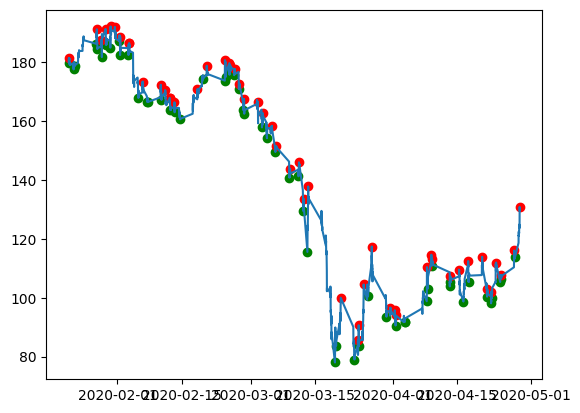

In [20]:
plt.scatter(df.index, df['min'], c='g')
plt.scatter(df.index, df['max'], c='r')
plt.plot(df.index, df['Close'])
plt.show()

In [21]:
!pip install dtaidistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.4 MB/s eta 0:00:00


# Metrics Explanation

## Pearson Correlation
Pearson correlation measures the linear relationship between two datasets. The value ranges from -1 to 1.
- **-1**: Perfect negative linear relationship
- **0**: No linear relationship
- **1**: Perfect positive linear relationship
High absolute values (close to -1 or 1) indicate a strong linear relationship, while values close to 0 indicate a weak linear relationship.

## Spearman Correlation
Spearman correlation measures the monotonic relationship between two datasets. Like Pearson correlation, its value ranges from -1 to 1.
- **-1**: Perfect negative monotonic relationship
- **0**: No monotonic relationship
- **1**: Perfect positive monotonic relationship
High absolute values (close to -1 or 1) indicate a strong monotonic relationship, while values close to 0 indicate a weak monotonic relationship.

## Granger Causality Test
The Granger Causality Test checks whether changes in one time series are predictive of changes in another. The p-value from this test is used to determine the significance of the results. A common threshold for significance is 0.05.
- **p <= 0.05**: The changes in one series are predictive of changes in the other (Reject the null hypothesis)
- **p > 0.05**: The changes in one series are not predictive of changes in the other (Fail to reject the null hypothesis)

## Cross-Correlation
Cross-correlation measures how well two series "match" when shifted in time. The value can range from -1 to 1, similar to Pearson correlation. High absolute values indicate a stronger relationship.

## Dynamic Time Warping (DTW)
DTW is a measure of similarity between two temporal sequences, which may vary in speed. It's often used in time series classification. Lower values indicate that the sequences are more similar.


In [22]:
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance
from scipy.signal import correlate
from scipy.spatial.distance import euclidean
import numpy as np
from dtaidistance import dtw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mutual_info_score

results = {}

# List of signal columns to compare with the ground truth
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Ground truth series
ground_truth = df['signal']
print(f"Shape of ground truth: {ground_truth.shape}")
batch_size=38

for column in signal_columns:
    # Signal series
    signal = df[column]

    # Initialize lists to store batch-wise metrics for each column
    pearson_corrs = []
    spearman_corrs = []
    cross_corr_scores = []
    dtw_dists = []
    mutual_infos = []

    # Number of batches
    num_batches = len(signal) // batch_size

    for i in range(num_batches):
        # Get the batch of data
        batch_signal = signal[i*batch_size:(i+1)*batch_size]
        batch_ground_truth = ground_truth[i*batch_size:(i+1)*batch_size]

        # Check for variation in the data
        if np.std(batch_signal) == 0 or np.std(batch_ground_truth) == 0:
            continue

        # Pearson correlation
        pearson_corr = pearsonr(batch_signal, batch_ground_truth)[0]
        pearson_corrs.append(pearson_corr)

        # Spearman correlation
        spearman_corr = spearmanr(batch_signal, batch_ground_truth)[0]
        spearman_corrs.append(spearman_corr)

        # Cross-correlation
        norm_signal = (batch_signal - np.mean(batch_signal)) / (np.std(batch_signal) * len(batch_signal))
        norm_ground_truth = (batch_ground_truth - np.mean(batch_ground_truth)) / (np.std(batch_ground_truth))
        cross_corr_score = correlate(norm_signal, norm_ground_truth, mode='valid')[0]
        cross_corr_scores.append(cross_corr_score)

        # Dynamic Time Warping
        dtw_dist = dtw.distance(batch_signal, batch_ground_truth)
        dtw_dists.append(dtw_dist)

        # Mutual Information
        mutual_info = mutual_info_score(batch_signal, batch_ground_truth)
        mutual_infos.append(mutual_info)

    # Store the results
    results[column] = [np.mean(pearson_corrs), np.mean(spearman_corrs), np.mean(cross_corr_scores), np.mean(dtw_dists), np.mean(mutual_infos)]

# Print the results for each indicator
for column, metrics in results.items():
    print(f"Results for {column}:")
    print(f"Mean Pearson correlation: {metrics[0]}")
    print(f"Mean Spearman correlation: {metrics[1]}")
    print(f"Mean cross-correlation score: {metrics[2]}")
    print(f"Mean DTW distance: {metrics[3]}")
    print(f"Mean mutual information: {metrics[4]}\n")


Shape of ground truth: (2497,)
Results for sma_signal:
Mean Pearson correlation: 0.0104458751830921
Mean Spearman correlation: 0.010665632216228859
Mean cross-correlation score: 0.010445875183092113
Mean DTW distance: 1.4872399229367448
Mean mutual information: 0.027227754975507456

Results for sma_crossover_signal:
Mean Pearson correlation: 0.048711372407701084
Mean Spearman correlation: 0.048942695600476614
Mean cross-correlation score: 0.04871137240770109
Mean DTW distance: 1.488457728610376
Mean mutual information: 0.0346773920830924

Results for ema_signal:
Mean Pearson correlation: -0.025093865158488608
Mean Spearman correlation: -0.02522002856925894
Mean cross-correlation score: -0.025093865158488597
Mean DTW distance: 1.5074736975239276
Mean mutual information: 0.023882083488930173

Results for ema_crossover_signal:
Mean Pearson correlation: 0.02280898642879963
Mean Spearman correlation: 0.02311209957795379
Mean cross-correlation score: 0.02280898642879964
Mean DTW distance: 1.

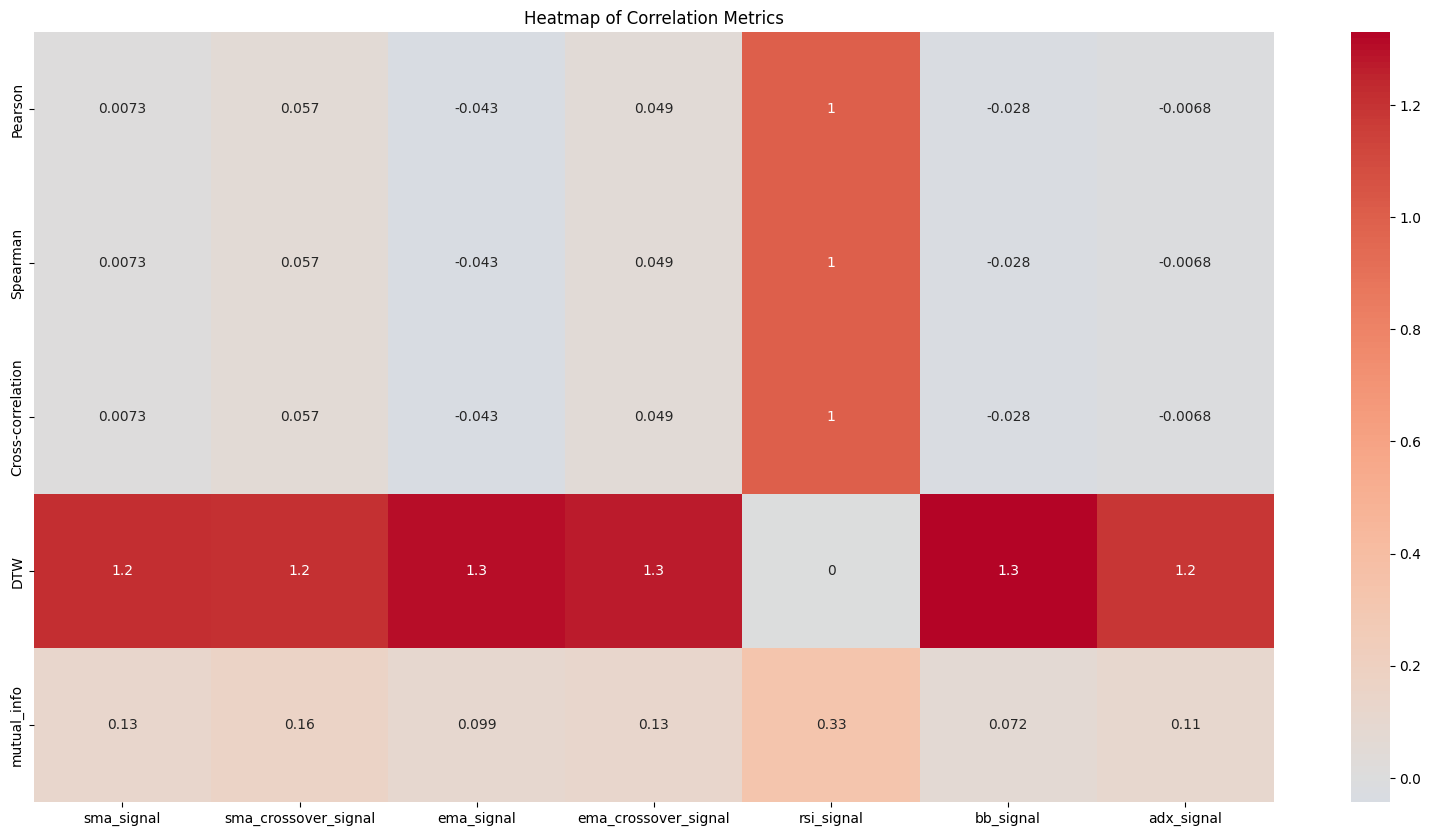

In [80]:
# Convert the results to a DataFrame
df_results = pd.DataFrame(results, index=['Pearson', 'Spearman', 'Cross-correlation', 'DTW',"mutual_info"])

# Plot a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(df_results, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlation Metrics')
plt.show()

**ASSOCIATION AND LAG ASSOCIATION METRICS**

In [23]:
count = (df["signal"] == df["sma_signal"]).sum()
count

2356

In [26]:
# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Lag', 'Count'])

# Loop over the range from -10 to +10
for lag in range(-10, 11):
    # Shift the sma_signal
    df['sma_signal_shifted'] = df['sma_signal'].shift(lag)

    # Calculate the count
    count = (df['signal'] == df['sma_signal_shifted']).sum()

    # Append the result to the report DataFrame
    report = report.append({'Lag': lag, 'Success': count/len(df)}, ignore_index=True)

# Remove the temporary shifted column
df.drop('sma_signal_shifted', axis=1, inplace=True)

# Print the report
print(report)


     Lag Count   Success
0  -10.0   NaN  0.939928
1   -9.0   NaN  0.938326
2   -8.0   NaN  0.937926
3   -7.0   NaN  0.937926
4   -6.0   NaN  0.939127
5   -5.0   NaN  0.939527
6   -4.0   NaN  0.939928
7   -3.0   NaN  0.939928
8   -2.0   NaN  0.940729
9   -1.0   NaN  0.942731
10   0.0   NaN  0.943532
11   1.0   NaN  0.943532
12   2.0   NaN  0.940729
13   3.0   NaN  0.941129
14   4.0   NaN  0.941129
15   5.0   NaN  0.941530
16   6.0   NaN  0.939127
17   7.0   NaN  0.939928
18   8.0   NaN  0.939127
19   9.0   NaN  0.939928
20  10.0   NaN  0.939127


In [25]:
# Define the list of signal columns
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Signal Column', 'Lag', 'Count'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Loop over the range from -10 to +10
    for lag in range(-10, 11):
        # Shift the signal column
        df[signal_column + '_shifted'] = df[signal_column].shift(lag)

        # Calculate the count
        count = (df['signal'] == df[signal_column + '_shifted']).sum()

        # Append the result to the report DataFrame
        report = report.append({'Signal Column': signal_column, 'Lag': lag, 'Count': count}, ignore_index=True)

    # Remove the temporary shifted column
    df.drop(signal_column + '_shifted', axis=1, inplace=True)

# Print the report
print(report)


    Signal Column  Lag Count
0      sma_signal  -10  2347
1      sma_signal   -9  2343
2      sma_signal   -8  2342
3      sma_signal   -7  2342
4      sma_signal   -6  2345
..            ...  ...   ...
142    adx_signal    6  2313
143    adx_signal    7  2315
144    adx_signal    8  2314
145    adx_signal    9  2318
146    adx_signal   10  2313

[147 rows x 3 columns]


In [42]:
df.sma_signal.value_counts()

 0    2455
 1      21
-1      21
Name: sma_signal, dtype: int64

In [46]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define the list of signal columns
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Signal Column', 'Lag', 'Precision', 'Recall', 'F1 Score'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Loop over the range from -10 to +10
    for lag in range(-10, 11):
        # Shift the signal column
        df[signal_column + '_shifted'] = df[signal_column].shift(lag)

        # Drop the NaN values from the shifted column
        shifted = df[signal_column + '_shifted'].dropna()

        # Calculate precision, recall, and F1 score
        precision = precision_score(df['signal'].loc[shifted.index], shifted, average='macro', zero_division=0)
        recall = recall_score(df['signal'].loc[shifted.index], shifted, average='macro', zero_division=0)
        f1 = f1_score(df['signal'].loc[shifted.index], shifted, average='macro', zero_division=0)

        # Append the result to the report DataFrame
        report = report.append({'Signal Column': signal_column, 'Lag': lag, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)

    # Remove the temporary shifted column
    df.drop(signal_column + '_shifted', axis=1, inplace=True)

# Print the report
report


,Signal Column,Lag,Precision,Recall,F1 Score
0,sma_signal,-10,0.382919,0.353207,0.359726
1,sma_signal,-9,0.335034,0.333796,0.332163
2,sma_signal,-8,0.319030,0.327598,0.323257
3,sma_signal,-7,0.318900,0.327461,0.323124
4,sma_signal,-6,0.334915,0.334139,0.332525
...,...,...,...,...,...
142,adx_signal,6,0.318859,0.323270,0.321049
143,adx_signal,7,0.328388,0.330082,0.328985
144,adx_signal,8,0.328382,0.329942,0.328913
145,adx_signal,9,0.347058,0.343066,0.344313


In [44]:
report.describe()

,Precision,Recall,F1 Score
count,147.000000,147.000000,147.000000
mean,0.336714,0.334774,0.333247
std,0.030579,0.007428,0.009891
min,0.318623,0.320894,0.319755
25%,0.319150,0.329020,0.325806
50%,0.334758,0.333945,0.332301
75%,0.341274,0.338027,0.338373
max,0.652627,0.359305,0.361523


**COINTEGRATION**

In [27]:
import statsmodels.api as sm

# Define the list of signal columns
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Signal Column', 'p-value'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Perform the cointegration test
    coint_t, p_value, crit_value = sm.tsa.stattools.coint(df['signal'], df[signal_column])

    # Append the result to the report DataFrame
    report = report.append({'Signal Column': signal_column, 'p-value': p_value}, ignore_index=True)

# Print the report
print(report)


          Signal Column       p-value
0            sma_signal  1.199304e-26
1  sma_crossover_signal  1.221510e-26
2            ema_signal  1.362062e-26
3  ema_crossover_signal  1.200489e-26
4            rsi_signal  1.514117e-26
5             bb_signal  1.268470e-26
6            adx_signal  1.202473e-26


**Lag Cross Correlation**

In [29]:
import numpy as np
import pandas as pd

# Define the list of signal columns
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Signal Column', 'Lag', 'Cross-correlation'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Loop over the range from -10 to +10
    for lag in range(-10, 11):
        # Shift the signal column
        shifted = df[signal_column].shift(lag).dropna()

        # Calculate the cross-correlation
        cross_correlation = np.correlate(df['signal'].loc[shifted.index], shifted)[0]

        # Append the result to the report DataFrame
        report = report.append({'Signal Column': signal_column, 'Lag': lag, 'Cross-correlation': cross_correlation}, ignore_index=True)

# Print the report
report


,Signal Column,Lag,Cross-correlation
0,sma_signal,-10,4.0
1,sma_signal,-9,0.0
2,sma_signal,-8,-1.0
3,sma_signal,-7,0.0
4,sma_signal,-6,1.0
...,...,...,...
142,adx_signal,6,-1.0
143,adx_signal,7,-1.0
144,adx_signal,8,0.0
145,adx_signal,9,1.0


In [31]:
report["Cross-correlation"].unique()

array([ 4.,  0., -1.,  1.,  2., -5., -4.,  3., -2., -3., -6., -7.,  5.])

In [33]:
import numpy as np
import pandas as pd

# Define the list of signal columns
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Signal Column', 'Lag', 'Normalized Cross-correlation'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Loop over the range from -10 to +10
    for lag in range(-10, 11):
        # Shift the signal column
        shifted = df[signal_column].shift(lag).dropna()

        # Calculate the cross-correlation
        cross_correlation = np.correlate(df['signal'].loc[shifted.index], shifted)[0]

        # Normalize the cross-correlation
        norm_cross_correlation = cross_correlation / (np.sqrt(np.sum(df['signal'].loc[shifted.index]**2)) * np.sqrt(np.sum(shifted**2)))

        # Append the result to the report DataFrame
        report = report.append({'Signal Column': signal_column, 'Lag': lag, 'Normalized Cross-correlation': norm_cross_correlation}, ignore_index=True)

report


,Signal Column,Lag,Normalized Cross-correlation
0,sma_signal,-10,0.059949
1,sma_signal,-9,0.000000
2,sma_signal,-8,-0.014987
3,sma_signal,-7,0.000000
4,sma_signal,-6,0.014987
...,...,...,...
142,adx_signal,6,-0.011368
143,adx_signal,7,-0.011368
144,adx_signal,8,0.000000
145,adx_signal,9,0.011422


In [36]:
report["Normalized Cross-correlation"].max(),report["Normalized Cross-correlation"].min()

(0.09667364890456635, -0.10836121044482575)

In [37]:
report.head(25)

,Signal Column,Lag,Normalized Cross-correlation
0,sma_signal,-10,0.059949
1,sma_signal,-9,0.000000
2,sma_signal,-8,-0.014987
3,sma_signal,-7,0.000000
4,sma_signal,-6,0.014987
5,sma_signal,-5,0.014987
6,sma_signal,-4,0.014987
7,sma_signal,-3,-0.014987
8,sma_signal,-2,0.014987
9,sma_signal,-1,0.029834


**Sliding window Cross Correlation and averaging**

In [53]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define the list of signal columns
signal_columns = ['sma_signal', 'sma_crossover_signal', 'ema_signal', 'ema_crossover_signal', 'rsi_signal', 'bb_signal', 'adx_signal']

# Create an empty DataFrame to store the results
report = pd.DataFrame(columns=['Signal Column', 'Window Size', 'Average Cross Correlation', 'Average Pearson Correlation', 'Average Spearman Correlation'])

# Loop over the signal columns
for signal_column in signal_columns:
    # Loop over the window sizes from 10 to 38*2
    for window_size in range(10, 38*2 + 1):
        # Calculate the rolling window cross correlation
        cross_corr = df['signal'].rolling(window=window_size).corr(df[signal_column])
        avg_cross_corr = cross_corr.mean()

        # Calculate the rolling window Pearson correlation
        pearson_corr = df['signal'].rolling(window=window_size).corr(df[signal_column], method='pearson')
        avg_pearson_corr = pearson_corr.mean()

        # Calculate the rolling window Spearman correlation
        spearman_corr = df['signal'].rolling(window=window_size).corr(df[signal_column], method='spearman')
        avg_spearman_corr = spearman_corr.mean()

        # Append the result to the report DataFrame
        report = report.append({'Signal Column': signal_column, 'Window Size': window_size, 'Average Cross Correlation': avg_cross_corr, 'Average Pearson Correlation': avg_pearson_corr, 'Average Spearman Correlation': avg_spearman_corr}, ignore_index=True)

# Print the report
report


,Signal Column,Window Size,Average Cross Correlation,Average Pearson Correlation,Average Spearman Correlation
0,sma_signal,10,0.064848,0.064848,0.064848
1,sma_signal,11,0.056091,0.056091,0.056091
2,sma_signal,12,0.050508,0.050508,0.050508
3,sma_signal,13,0.046539,0.046539,0.046539
4,sma_signal,14,0.041903,0.041903,0.041903
...,...,...,...,...,...
464,adx_signal,72,0.003917,0.003917,0.003917
465,adx_signal,73,0.004091,0.004091,0.004091
466,adx_signal,74,0.004287,0.004287,0.004287
467,adx_signal,75,0.004511,0.004511,0.004511


**Wavelet Coherence**

**Transfer entropy**

**Recurrence Quantification Analysis**

**BACKTESTING AGAIN USING THE INFLECTION POINTS COLUMN and updating METRICS dataframe for all Indicators**

In [ ]:
# def backtest(df, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage):
#     df['signal'] = df['inflection_points']  # Use 'inflection_points' as signal
#     in_position = False
#     capital = starting_capital
#     num_trades = 0
#     wins = []
#     losses = []
#     daily_profits=[]

#     for day in np.unique(df.index.date):
#         df_day = df[df.index.date == day]
#         profits = []
#         for index, row in df_day.iterrows():
#             volume_limit = row.Volume * volume_percentage
#             if not in_position and row.signal == 1:  # Buy signal
#                 buyprice = row.Close
#                 shares_to_trade = min(volume_limit, upper_cap // buyprice)
#                 investment = buyprice * shares_to_trade

#                 if investment > capital * leverage or investment >upper_cap or investment < lower_cap:
#                     continue

#                 capital -= investment * (1 + transaction_cost)
#                 in_position = True

#             if in_position and (row.signal == -1 and row.Close < buyprice * (1 - stop_loss)):  # Sell signal or stop loss
#                 sell_proceeds = row.Close * shares_to_trade
#                 profit = sell_proceeds - investment
#                 profits.append(profit)
#                 capital += sell_proceeds * (1 - transaction_cost)
#                 in_position = False
#                 num_trades += 1
#                 if profit > 0:
#                     wins.append(profit)
#                 else:
#                     losses.append(profit)

#             # If still in position at the end of the day, sell
#             if in_position and index == df_day.index[-1]:
#                 sell_proceeds = row.Close * shares_to_trade
#                 profit = sell_proceeds - investment
#                 profits.append(profit)
#                 capital += sell_proceeds * (1 - transaction_cost)
#                 in_position = False
#                 num_trades += 1
#                 if profit > 0:
#                     wins.append(profit)
#                 else:
#                     losses.append(profit)

#         daily_profits.append(sum(profits))

#     daily_profits = pd.Series(daily_profits)
#     hit_rate = (daily_profits > 0).mean()
#     profit_factor = daily_profits[daily_profits > 0].sum() / -daily_profits[daily_profits < 0].sum()
#     sharpe_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits.std()
#     sortino_ratio = np.sqrt(len(df)) * daily_profits.mean() / daily_profits[daily_profits < 0].std()
#     max_drawdown = np.min(daily_profits)
#     total_profit = capital - starting_capital
#     profit_percentage = (total_profit / starting_capital) * 100
#     avg_win_to_avg_loss_ratio = np.abs(np.mean(wins) / np.mean(losses))

#     return df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades


# # Call the backtest function
# df, hit_rate, profit_factor, sharpe_ratio, max_drawdown, total_profit, profit_percentage, avg_win_to_avg_loss_ratio, sortino_ratio, num_trades = backtest(df, starting_capital, stop_loss, upper_cap, lower_cap, transaction_cost, leverage, volume_percentage)

# # Print the metrics
# print(f"Hit Rate: {hit_rate}")
# print(f"Profit Factor: {profit_factor}")
# print(f"Sharpe Ratio: {sharpe_ratio}")
# print(f"Max Drawdown: {max_drawdown}")
# print(f"Total Profit: {total_profit}")
# print(f"Profit Percentage: {profit_percentage}")
# print(f"Average Win to Average Loss Ratio: {avg_win_to_avg_loss_ratio}")
# print(f"Sortino Ratio: {sortino_ratio}")
# print(f"Number of Trades: {num_trades}")

# metrics_df = metrics_df.append({
#     "Indicator":"Inflection Points",
#     'Best_n': 20,
#     'Best_m': None,
#     'Hit_Rate': hit_rate,
#     'Profit_Factor': profit_factor,
#     'Sharpe_Ratio': sharpe_ratio,
#     'Max_Drawdown': max_drawdown,
#     'Total_Profit': total_profit,
#     'Profit_Percentage': profit_percentage,
#     'Avg_Win_to_Avg_Loss_Ratio': avg_win_to_avg_loss_ratio,
#     'Sortino_Ratio': sortino_ratio,
#     'Num_Trades': num_trades
# }, ignore_index=True)


Hit Rate: 0.45454545454545453
Profit Factor: 64.38085327783597
Sharpe Ratio: 22.65530488376612
Max Drawdown: -65.10000000000036
Total Profit: 5546.055000000026
Profit Percentage: 55.460550000000254
Average Win to Average Loss Ratio: 8.58411377037813
Sortino Ratio: 146.4416714635465
Number of Trades: 34


# **Report Obtained for each Indicator**
**The reports include these:**

(i)  Indicator

(ii) Best Window sizes(small +big)

(iii) Hit Rate/Win rate

(iv) Profit Factor

(v) Sharpe Ratio

(vi) Max Drawdown

(vii) Total profit

(viii) Profit Percentage

(ix) Average Win to Average Loss Ratio

(x) Sortino Ratio

(xi) Number of Trades

In [ ]:
metrics_df.head(10)

,Indicator,Best_n,Best_m,Hit_Rate,Profit_Factor,Sharpe_Ratio,Max_Drawdown,Total_Profit,Profit_Percentage,Avg_Win_to_Avg_Loss_Ratio,Sortino_Ratio,Num_Trades
0,SMA,527,None,0.181818,1.980214,7.296833,-411.40,1438.295600,14.382956,1.485161,10.209546,21
1,SMA_Crossover,564,4,0.166667,2.370887,8.357021,-384.80,1612.681500,16.126815,-1.724281,12.896507,19
2,RSI,117,None,0.030303,-inf,8.440356,0.00,1939.418850,19.394189,NaN,NaN,2
3,ADX,46,None,0.287879,2.600435,11.038252,-361.35,2282.947000,22.829470,-1.913059,19.731586,37
4,Bollinger Bands,73,None,0.151515,2.617721,8.089186,-287.55,1686.323850,16.863239,-2.617721,14.582495,20
5,EMA,65,None,0.333333,2.599868,10.709183,-458.80,3360.744404,33.607444,2.430250,27.239468,45
6,EMA_Crossover,374,5,0.227273,1.466662,4.798143,-458.80,588.591170,5.885912,-1.564439,7.006364,31
7,Inflection Points,20,None,0.454545,64.380853,22.655305,-65.10,5546.055000,55.460550,8.584114,146.441671,34


# **Plots and Vizualizations for selective Indicators**

In [ ]:
df2=df.copy()
df2.reset_index(level=0, inplace=True)
df2.rename(columns={'index': 'Date'}, inplace=True)
# callable plotting function
def plot_df(columns, date_range):
    if columns:  # Check if any column is selected
        fig, ax = plt.subplots(figsize=(50, 20))  # Create a figure and a set of subplots
        df2.set_index('Date').loc[date_range[0]:date_range[1], list(columns)].plot(ax=ax)  # Plot on the specific axes
        ax.grid(True)
        ax.legend(fontsize="40")  # Increase the legend size

        font = {'weight' : 'bold',
                'size'   : 22}

        plt.rc('font', **font)
        plt.show()

# Getting column names from the dfFrame
column_names = [col for col in df2.columns.tolist() if col != 'Date']

# Here creating date range slider
dates = pd.date_range(df2['Date'].min(), df2['Date'].max(), freq='D')
options = [(date.strftime(' %d %b %Y '), date) for date in dates]
date_range_slider = SelectionRangeSlider(
    options=options,
    index=(0, len(options)-1),
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)


# Plotting interactive plot
interact(plot_df, columns=SelectMultiple(options=column_names), date_range=date_range_slider)

interactive(children=(SelectMultiple(description='columns', options=('Open', 'High', 'Low', 'Close', 'Volume',…

<function __main__.plot_df(columns, date_range)>